# Homework 3 - Neo4j
Advanced Information Systems and Big Data - A.Y. 2025-2026

Dataset: Artificial Intelligence Publication Trends (arXiv)

### Environment

In [ ]:
# IMPORT
import pandas as pd
import numpy as np
from neo4j import GraphDatabase
from IPython.display import Image, display
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
import networkx as nx
from ast import literal_eval
import warnings
import re
warnings.filterwarnings('ignore') # (to avoid warnings)

# INSTALL
%pip install neo4j pandas networkx matplotlib -q

### Neo4j

In [ ]:
# SETUP NEO4J: Local Client
URI = "bolt://localhost:7687" 
USER = "neo4j"
PASSWORD = "Advanced Information Systems and Big Data - A.Y. 2025-2026"

# DATABASE CONNECTION
driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

# function to execute queries
def run_query(query, params=None):
    with driver.session(
        notifications_disabled_classifications=["GENERIC", "DEPRECATION"] # (to avoid warnings)
    ) as session:
        result = session.run(query, params or {}) # (executes query)
        return [record.data() for record in result] 

In [ ]:
# CARICAMENTO DATASET
# Dataset: pubblicazioni AI da arXiv (8000 paper, 132 topic).

df_papers = pd.read_csv("arxiv_papers.csv") # (carica dataset pubblicazioni)
df_topics = pd.read_csv("papers_with_topics.csv") # (carica dataset assegnazione topic)
df_topic_defs = pd.read_csv("topic_definitions.csv") # (carica dataset nomi/descrizioni dei topic)

print(f"Papers: {len(df_papers)}")
print(f"Papers con topics: {len(df_topics)}")
print(f"Topic definitions: {len(df_topic_defs)}")

# # Il merge collega ogni paper ai suoi topic.
df = df_papers.merge(df_topics, on='url', how='inner')

Papers: 8000
Papers con topics: 8000
Topic definitions: 132


## Creazione del Grafo

### Vincoli

In [ ]:
# CREAZIONE VINCOLI DI UNICITÀ
# I vincoli garantiscono integrità e impediscono duplicati

# Vincolo: ogni Paper deve avere una url unica
run_query("""
CREATE CONSTRAINT IF NOT EXISTS
FOR (p:Paper)
REQUIRE p.url IS UNIQUE
""")

# Vincolo: ogni Author deve avere un nome unico
run_query("""
CREATE CONSTRAINT IF NOT EXISTS
FOR (a:Author)
REQUIRE a.name IS UNIQUE
""")
# Vincolo: ogni Topic deve avere un id unico
run_query("""
CREATE CONSTRAINT IF NOT EXISTS
FOR (t:Topic)
REQUIRE t.id IS UNIQUE
""")

# Controllo numero vincoli creati
result = run_query("""
SHOW CONSTRAINTS
""")
n_constraints = len(list(result))
print(f"Vincoli totali: {n_constraints}")

Vincoli totali: 3


### Nodi

In [ ]:
# CREAZIONE NODI TOPIC
# Ogni topic diventa un nodo.

for _, row in df_topic_defs.iterrows(): # csv dei topic
    topic_id = int(row['Topic'])
    name = str(row['Name']) if pd.notna(row['Name']) else f"topic_{topic_id}"

    # crea nodo topic con MERGE (trova o crea)
    #   id: identificativo numerico
    #   name: nome descrittivo del topic
    run_query("""
        MERGE (t:Topic {id: $id})
        SET t.name = $name
    """, {
        'id': topic_id,
        'name': name
    })


# Controllo numero nodi Topic creati
result = run_query("""
MATCH (t:Topic)
RETURN count(t) AS n
""")
n_topics = result[0]["n"]
print(f"Nodi Topic totali: {n_topics}")

Nodi Topic totali: 132


In [ ]:
# CREAZIONE NODI PAPER
# Ogni pubblicazione arXiv diventa un nodo.

for _, row in df.iterrows(): # csv dei paper
    date_str = str(row['published'])[:10] if pd.notna(row['published']) else ''

    # crea nodo paper con MERGE (trova o crea)
    #   url: identificativo unico (link arXiv)
    #   title: titolo del paper
    #   abstract: riassunto (troncato a 5000 caratteri per performance)
    #   date: data di pubblicazione (YYYY-MM-DD)
    run_query("""
        MERGE (p:Paper {url: $url})
        SET p.title = $title,
            p.abstract = $abstract,
            p.date = $date
    """, {
        'url': row['url'],
        'title': str(row['title']) if pd.notna(row['title']) else '',
        'abstract': str(row['abstract'])[:5000] if pd.notna(row['abstract']) else '',
        'date': date_str
    })


# Controllo numero nodi Paper creati
result = run_query("""
MATCH (p:Paper)
RETURN count(p) AS n
""")
n_paper = result[0]["n"]
print(f"Nodi Paper totali: {n_paper}")

Nodi Paper totali: 8000


In [ ]:
# CREAZIONE NODI AUTHOR
# Ogni autore unico diventa un nodo.

for _, row in df.iterrows(): # csv dei paper
    if pd.notna(row['authors']):
        # parsing autori (stringa -> lista)
        authors = [a.strip() for a in str(row['authors']).split(',') if a.strip()]
        
        for author in authors:
            # Rimuove [ ] ' e spazi multipli per pulizia
            clean_name = re.sub(r"[\[\]']", "", author).strip()

            # crea nodo autore con MERGE (trova o crea)
            #   name: nome autore
            run_query(
                "MERGE (a:Author {name: $name})",
                {'name': clean_name}
            )


# Controllo numero nodi Author creati
result = run_query("""
MATCH (a:Author)
RETURN count(a) AS n
""")
n_author = result[0]["n"]
print(f"Nodi Author totali: {n_author}")

Nodi Author totali: 37604


### Relazioni

In [ ]:
# CREAZIONE RELAZIONI AUTHORED
# Collega ogni autore ai suoi paper.

for _, row in df.iterrows(): # csv dei paper
    if pd.notna(row['authors']):
        # parsing autori (stringa -> lista)
        authors = [a.strip() for a in str(row['authors']).split(',') if a.strip()]

        # per ogni autore che ha scritto il paper crea relazione
        for author in authors:
            # Rimuove [ ] ' e spazi multipli per pulizia
            clean_name = re.sub(r"[\[\]']", "", author).strip()

            # cerca nodo con nome autore
            # cerca nodo con url paper
            # crea relazione authored con MERGE (trova o crea) tra autore e paper
            run_query("""
                MATCH (a:Author {name: $name})
                MATCH (p:Paper {url: $url})
                MERGE (a)-[:AUTHORED]->(p)
            """, {
                    'name': clean_name,
                    'url': row['url']
                })


# Controllo numero relazioni AUTHORED create
result = run_query("""
MATCH (:Author)-[r:AUTHORED]->(:Paper)
RETURN count(r) AS n
""")
n_authored = result[0]["n"]
print(f"Relazioni Authored totali: {n_authored}")

Relazioni Authored totali: 44460


In [ ]:
# CREAZIONE RELAZIONI ON_TOPIC
# Collega ogni paper ai suoi topic con probabilità.

for _, row in df.iterrows(): # csv dei paper
    try:
        # conversione stringa -> lista dei 3 topic più probabili
        top_topics = literal_eval(row['top_topics']) if isinstance(row['top_topics'], str) else row['top_topics']
        # conversione stringa -> lista delle 3 probabilità più alte dei topic
        top_probs = literal_eval(row['top_probabilities']) if isinstance(row['top_probabilities'], str) else row['top_probabilities']

        # per ogni topic e probabilità crea relazione
        for topic_id, prob in zip(top_topics, top_probs): # zip accoppia topic_id e prob corrispondente
            
            # cerca nodo con url paper
            # cerca nodo con id topic
            # crea relazione onTopic con MERGE (trova o crea) tra topic e paper
            # setta la probabilità corrsipondente
            run_query("""
                MATCH (p:Paper {url: $url})
                MATCH (t:Topic {id: $topic_id})
                MERGE (p)-[r:ON_TOPIC]->(t)
                SET r.probability = $prob
            """, {
                'url': row['url'],
                'topic_id': int(topic_id),
                'prob': float(prob)
            })
    except:
        pass


# Controllo numero relazioni ON_TOPIC create
result = run_query("""
MATCH (:Paper)-[r:ON_TOPIC]->(:Topic)
RETURN count(r) AS n
""")
n_on_topic = result[0]["n"]
print(f"Relazioni ON_TOPIC totali: {n_on_topic}")

Relazioni ON_TOPIC totali: 24000


In [ ]:
# CREAZIONE RELAZIONI COAUTHORED_WITH
# Collega autori che hanno scritto paper insieme.
#
#   utilizzo di CYPHER CON APOC:
#     apoc.periodic.iterate() esegue operazioni in batch.
#     Necessario per grandi volumi (evita OutOfMemory).
      # 2 types of query:
      # --> iterable query
      # --> action query
batch_size = 500


# Trova coppie (a1, a2) che hanno entrambi scritto gli stessi paper.
# WHERE id(a1) < id(a2) evita duplicati (a1-a2 e a2-a1).
# Salva Proprietà su Relazione: papers_count = numero di paper co-scritti dalla coppia.
coauthored_query = """
    CALL apoc.periodic.iterate(
      "
        MATCH (a1:Author)-[:AUTHORED]->(p:Paper)<-[:AUTHORED]-(a2:Author)
        WHERE id(a1) < id(a2)
        RETURN a1, a2, COUNT(p) AS papers_count
      ",
      "
        MERGE (a1)-[r:COAUTHORED_WITH]-(a2)
        SET r.papers_count = papers_count
      ",
      {
          batchSize: $batch_size,
          parallel: false
      }
    )
"""
# parallel=false per evitare incoerenze date da salvataggi concorrenti
run_query(coauthored_query, {"batch_size": batch_size})


# Controllo numero relazioni COAUTHORED_WITH create
result = run_query("""
MATCH (:Author)-[r:COAUTHORED_WITH]-(:Author)
RETURN count(r) AS n
""")
n_coauthored = result[0]["n"]
print(f"Relazioni COAUTHORED_WITH totali: {n_coauthored}")

Relazioni COAUTHORED_WITH totali: 2844978


In [ ]:
# CREAZIONE RELAZIONI SIMILAR_TOPIC
# Collega paper con topic simili (Jaccard similarity > 0.3).
#
#   utilizzo di CYPHER CON APOC:
#     apoc.periodic.iterate() esegue operazioni in batch.
#     Necessario per grandi volumi (evita OutOfMemory).
      # 2 types of query:
      # --> iterable query
      # --> action query
batch_size = 1000


# Trova coppie (p1, p2) che hanno entrambi gli stessi topic.
# WHERE id(p1) < id(p2) evita duplicati (p1-p2 e p2-p1).
# Salva Proprietà su Relazione: similarity = somiglianza sulla base dei topic condivisi, calcolata con Jaccard
#   SIMILARITÀ JACCARD PESATA: jaccard_sim = sum_min / sum_max
#     Per ogni coppia di paper (p1, p2) che condividono almeno un topic:
#     - sum_min: somma dei MIN delle probabilità per ogni topic comune
#     - sum_max: somma dei MAX delle probabilità per ogni topic comune
#   Solo coppie con similarità > 30% vengono collegate.
#   (Riduce il numero di relazioni (per performance) mantenendo quelle significative)
similar_query = """
    CALL apoc.periodic.iterate(
      "
        MATCH (p1:Paper)-[r1:ON_TOPIC]->(t:Topic)<-[r2:ON_TOPIC]-(p2:Paper)
        WHERE id(p1) < id(p2)
        WITH p1, p2,
             SUM(CASE WHEN r1.probability < r2.probability THEN r1.probability ELSE r2.probability END) AS sum_min,
             SUM(CASE WHEN r1.probability > r2.probability THEN r1.probability ELSE r2.probability END) AS sum_max
        WHERE sum_max > 0
        WITH p1, p2, 
            sum_min / sum_max AS jaccard_sim
        WHERE jaccard_sim > 0.3
        RETURN p1, p2, jaccard_sim
      ",
      "
        MERGE (p1)-[r:SIMILAR_TOPIC]-(p2)
        SET r.similarity = jaccard_sim
      ",
      {
          batchSize: $batch_size,
          parallel: false}
    )
"""
# parallel=false per evitare incoerenze date da salvataggi concorrenti
run_query(similar_query, {"batch_size": batch_size})


# Controllo numero relazioni SIMILAR_TOPIC create
result = run_query("""
MATCH (:Paper)-[r:SIMILAR_TOPIC]-(:Paper)
RETURN count(r) AS n
""")
n_similar = result[0]["n"]
print(f"Relazioni SIMILAR_TOPIC totali: {n_similar}")

Relazioni SIMILAR_TOPIC totali: 1393172


## Interrogazioni

### Query 1: Schema

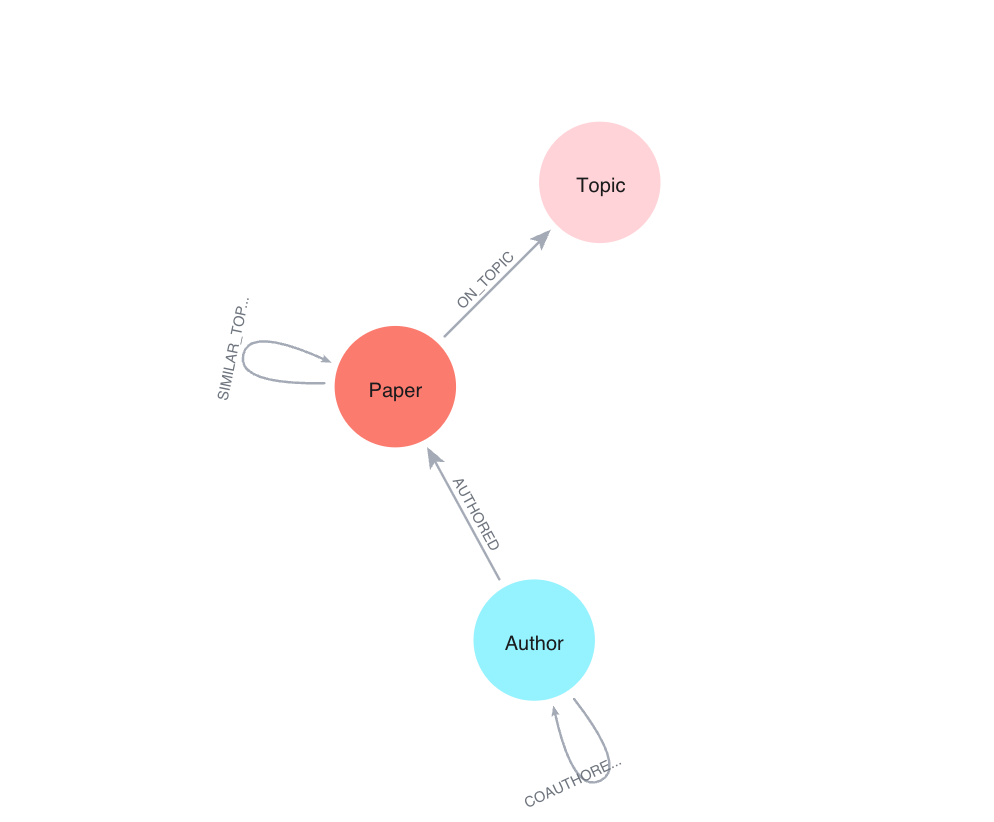

In [ ]:
# QUERY 1: VISUALIZATION SCHEMA
print("Query su Neo4j Desktop: 'CALL db.schema.visualization()'") # mostra il grafo dello schema

display(Image(filename='visualisation1.png'))

### Query 2: Top 5 autori

In [ ]:
# QUERY 2: TOP 5 AUTORI PIÙ PROLIFICI

# MATCH trova tutte le relazioni Author→Paper
# count(p) conta i paper per ogni autore 
# ORDER BY + LIMIT seleziona i top 5
result = run_query("""
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)
    RETURN a.name as author, count(p) as papers
    ORDER BY papers DESC
    LIMIT 5
""")

for r in result:
    print(f"  {r['author']}: {r['papers']} articoli")

  Wei Wang: 19 articoli
  Yang Li: 19 articoli
  Yang Liu: 18 articoli
  Xin Wang: 15 articoli
  H. Vincent Poor: 13 articoli


### Query 3: Andamento temporale

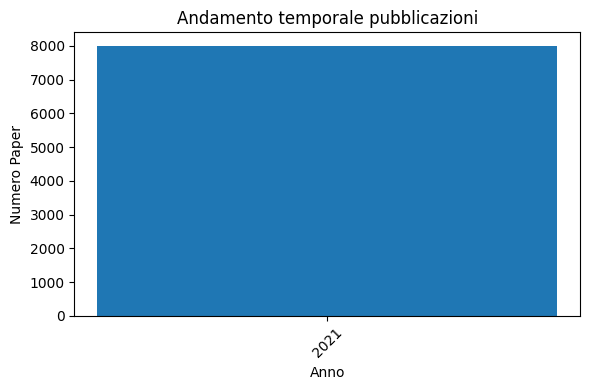

In [ ]:
# QUERY 3: ANDAMENTO TEMPORALE PUBBLICAZIONI PER ANNO

# tra tutti i Paper WHERE p.date <> '' esclude paper senza data
# substring(p.date, 0, 4) estrae l'anno (primi 4 caratteri YYYY-MM-DD)
result = run_query("""
    MATCH (p:Paper)
    WHERE p.date <> ''
    RETURN substring(p.date, 0, 4) AS year, count(*) AS papers
    ORDER BY year
""")

years = [r['year'] for r in result]
counts = [r['papers'] for r in result]

plt.figure(figsize=(6,4))
plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Numero Paper')
plt.title('Andamento temporale pubblicazioni')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

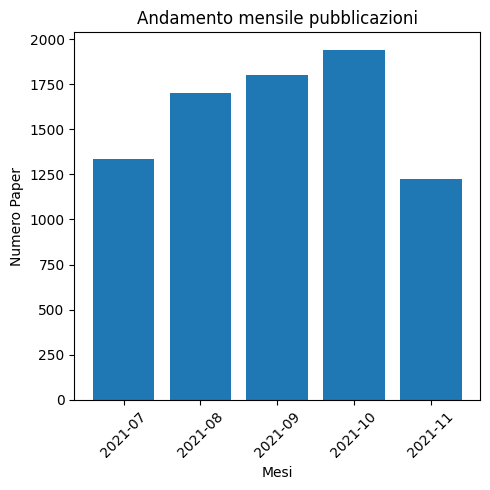

In [ ]:
# ANDAMENTO TEMPORALE PUBBLICAZIONI PER MESE

# tra tutti i Paper WHERE p.date <> '' esclude paper senza data
# substring(p.date, 5, 7) estrae il mese YYYY-MM-DD
result = run_query("""
    MATCH (p:Paper)
    WHERE p.date <> ''
    RETURN substring(p.date, 0, 7) AS month, count(p) AS papers
    ORDER BY month
""")

months = [r['month'] for r in result]
counts = [r['papers'] for r in result]

plt.figure(figsize=(5, 5))
plt.bar(months, counts)
plt.xlabel('Mesi')
plt.ylabel('Numero Paper')
plt.title('Andamento mensile pubblicazioni')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Query 4: Percorso piu breve tra due autori

In [ ]:
# SELEZIONE AUTORI PER SHORTEST PATH
# Scegliamo due autori prolifici (per Paper) per trovare il percorso più breve.

top_authors = run_query("""
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)
    RETURN a.name as name, count(p) as papers
    ORDER BY papers DESC
    LIMIT 10
""")

# Scelgo il 1° e il 6° autore più prolifico per garantire che non siano direttamente collegati
author1 = top_authors[0]['name']
author2 = top_authors[5]['name']

print(f"Autori selezionati: {author1}, {author2}")

Autori selezionati: Yang Li, H. Vincent Poor


In [ ]:
# QUERY 4: SHORTEST PATH TRA DUE AUTORI
# Trova il percorso più breve nel grafo delle co-autorship.


# shortestPath((a1)-[*]-(a2)): algoritmo BFS per trovare cammino minimo
#   [*]: attraversa qualsiasi tipo di relazione tra i due autori
# RETURN i nodi nel percorso ( estratti con nodes(path)) e la length
path = run_query("""
    MATCH (a1:Author {name: $author1}), (a2:Author {name: $author2})
    MATCH path = shortestPath((a1)-[*]-(a2))
    RETURN [n IN nodes(path) |
        CASE WHEN n:Author THEN 'Author: ' + n.name
             WHEN n:Paper THEN 'Paper: ' + substring(n.title, 0, 50) + '...'
             ELSE 'Node' END
    ] as pathNodes, length(path) as pathLength
""", {'author1': author1, 'author2': author2})

print(f"Lunghezza percorso: {path[0]['pathLength']}")
print("\nPercorso:")
for node in path[0]['pathNodes']:
    print(f"  -> {node}")

Lunghezza percorso: 4

Percorso:
  -> Author: Yang Li
  -> Paper: Coordinating Flexible Demand Response and Renewabl...
  -> Paper: SmartSlice: Dynamic, self-optimization of applicat...
  -> Paper: Timely Status Updating Over Erasure Channels Using...
  -> Author: H. Vincent Poor


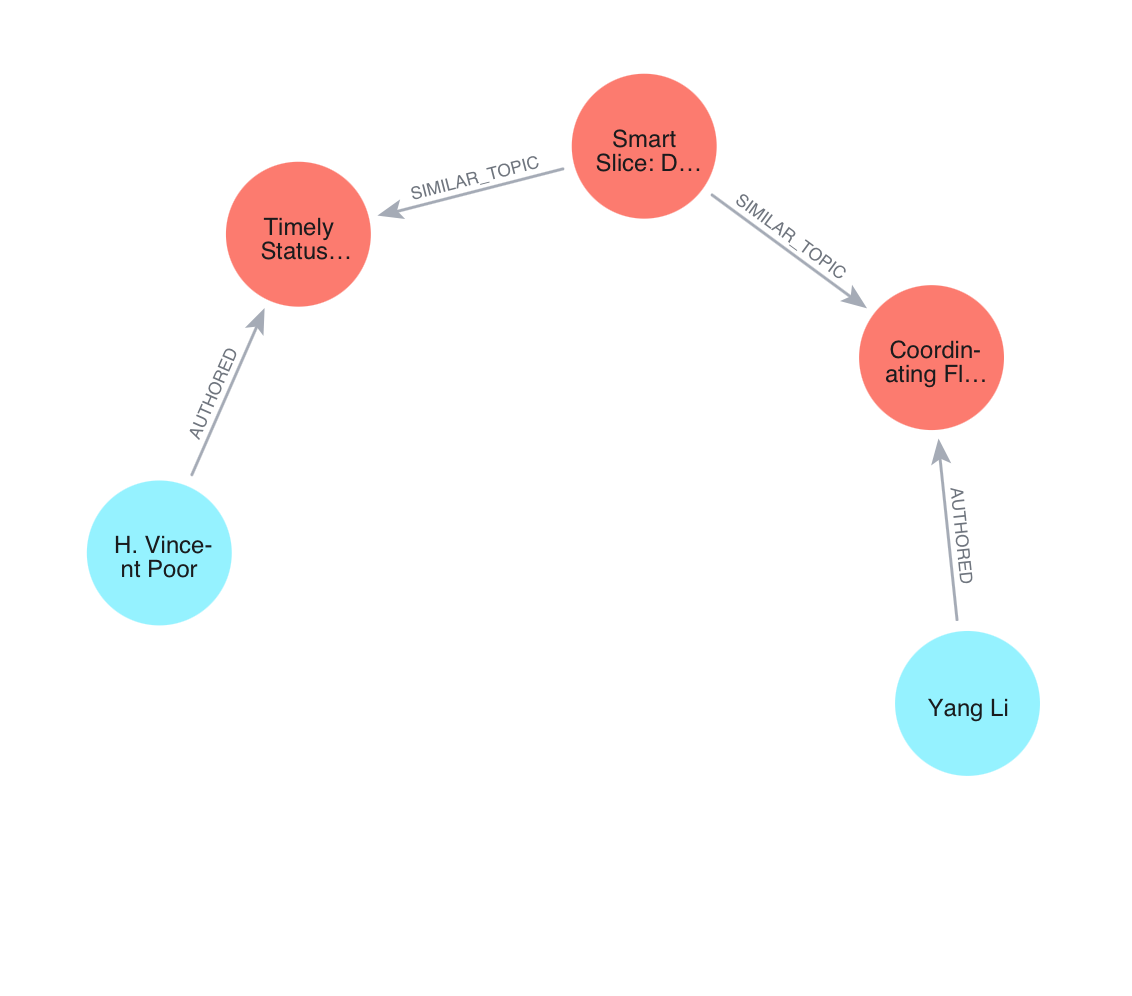

In [22]:
display(Image(filename='visualisation2.png'))

### Query 5: Similarita autori

Calcola la similarità tra coppie di autori basata sui topic dei loro paper.

**Formula:** $Sim(a_1, a_2) = \frac{1}{|P_1| \cdot |P_2|} \sum_{p_i \in P_1, p_j \in P_2} simT(p_i, p_j)$

In [ ]:
# FASE 1: CALCOLO |P1| e |P2|
# Conta paper distinti per ogni autore
author_papers = run_query("""
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)
    RETURN a.name AS author, COUNT(DISTINCT p) AS numPapers
""")

# salvataggio in coppie -> autore:numPapers
author_paper_count = {a['author']: a['numPapers'] for a in author_papers} 
print(f"Autori totali: {len(author_paper_count)}")

Autori totali: 37604


In [ ]:
# FASE 2: CALCOLO sum_{p_i \in P_1, p_j \in P_2} simT(p_i, p_j)

# Trova tutte le coppie distinte di paper con SIMILAR_TOPIC
#
# Per ogni coppia di paper trovata, recupera tutti gli autori
#    dei due paper e crea/aggiorna la relazione AUTHOR_SIM
# Somma le similarità della coppia con le precedenti (0 se null)
data = run_query("""
CALL apoc.periodic.iterate(

  "MATCH (p1:Paper)-[r:SIMILAR_TOPIC]->(p2:Paper) 
   WHERE id(p1)<id(p2) 
   RETURN p1,p2,r.similarity AS sim",
   
  "MATCH (a1:Author)-[:AUTHORED]->(p1)
   MATCH (a2:Author)-[:AUTHORED]->(p2)
   WHERE id(a1)<id(a2)
   MERGE (a1)-[s:AUTHOR_SIM]->(a2)
   SET s.totalSim = coalesce(s.totalSim,0) + sim",
   
  {batchSize:1000, parallel:false}
)
""")

# Legge tutte le relazioni AUTHOR_SIM create
data = run_query("""
MATCH (a1:Author)-[s:AUTHOR_SIM]->(a2:Author)
WHERE id(a1)<id(a2)
RETURN a1.name AS author1, a2.name AS author2, s.totalSim AS totalSim
""")

In [ ]:
# QUERY 5: CALCOLO SIMILARITÀ
# similarity = totalSim / (papers_a1 * papers_a2)

results = []

for row in data:
    a1, a2 = row['author1'], row['author2']
    total_sim = row['totalSim']

    p1 = author_paper_count[a1]
    p2 = author_paper_count[a2]

    similarity = total_sim / (p1 * p2)

    results.append({
        'author1': a1,
        'author2': a2,
        'similarity': similarity,
        'p1': p1,
        'p2': p2
    })
# ordino per similarità decrescente
results.sort(key=lambda x: x['similarity'], reverse=True)

print("Top 10 coppie di autori simili:")
for i, r in enumerate(results[:10], 1):
    print(
        f"{i}. {r['author1'][:30]} <-> {r['author2'][:30]}: "
        f"{r['similarity']:.4f} (|P1|={r['p1']}, |P2|={r['p2']})"
    )

Top 10 coppie di autori simili:
1. Mi Luo <-> Zhiqiang Shen: 1.0000 (|P1|=1, |P2|=1)
2. Mi Luo <-> Zechun Liu: 1.0000 (|P1|=1, |P2|=1)
3. Mi Luo <-> Junlin Liu: 1.0000 (|P1|=1, |P2|=1)
4. Mi Luo <-> Zhenyu Gu: 1.0000 (|P1|=1, |P2|=1)
5. Mi Luo <-> Hongxu Yin: 1.0000 (|P1|=1, |P2|=1)
6. Mi Luo <-> Pavlo Molchanov: 1.0000 (|P1|=1, |P2|=1)
7. Mi Luo <-> Steven Walton: 1.0000 (|P1|=1, |P2|=1)
8. Mi Luo <-> Ye Lin: 1.0000 (|P1|=1, |P2|=1)
9. Mi Luo <-> Yanyang Li: 1.0000 (|P1|=1, |P2|=1)
10. Mi Luo <-> Xue Wang: 1.0000 (|P1|=1, |P2|=1)


### Query 6: Rete co-authorship top 20 autori

In [5]:
# QUERY 6: RETE CO-AUTHORSHIP TOP 20 AUTORI

# Trova tutti gli autori e conta quanti paper hanno scritto
#   limitando ai 20 più prolifici
# Genera tutte le coppie possibili di questi 20 autori con UNWIND
# Trova relazioni di co-autorship tra queste coppie di autori distinti
coauth_result = run_query("""
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)
    WITH a, count(p) as papers
    ORDER BY papers DESC
    LIMIT 20
    WITH collect(a) as topAuthors
    UNWIND topAuthors as a1
    UNWIND topAuthors as a2
    MATCH (a1)-[r:COAUTHORED_WITH]-(a2)
    WHERE id(a1) < id(a2)
    RETURN a1.name as author1, a2.name as author2, r.papers_count as papers
    ORDER BY papers DESC
""")

print(f"Connessioni tra top 20 autori: {len(coauth_result)}")

Connessioni tra top 20 autori: 13


In [6]:
print("Top 10 collaborazioni:")
for r in coauth_result[:10]:

    # Normalizzazione: prendo il primo elemento se è lista, altrimenti uso stringa
    a1 = r['author1'][0] if isinstance(r['author1'], list) else r['author1']
    a2 = r['author2'][0] if isinstance(r['author2'], list) else r['author2']

    # Parsing dai nomi
    a1 = str(a1).strip("[]'\" ")
    a2 = str(a2).strip("[]'\" ")

    print(f"  {a1} - {a2}: {r['papers']} paper")

Top 10 collaborazioni:
  Robert Schober - Derrick Wing Kwan Ng: 3 paper
  Wei Wang - Jun Luo: 2 paper
  H. Vincent Poor - Robert Schober: 2 paper
  H. Vincent Poor - Lajos Hanzo: 2 paper
  Lajos Hanzo - Derrick Wing Kwan Ng: 2 paper
  Wei Wang - Yang Liu: 1 paper
  Wei Wang - Jie Zhang: 1 paper
  Wei Wang - Jun Wang: 1 paper
  Wei Wang - Jun Liu: 1 paper
  Jie Zhang - Jun Wang: 1 paper


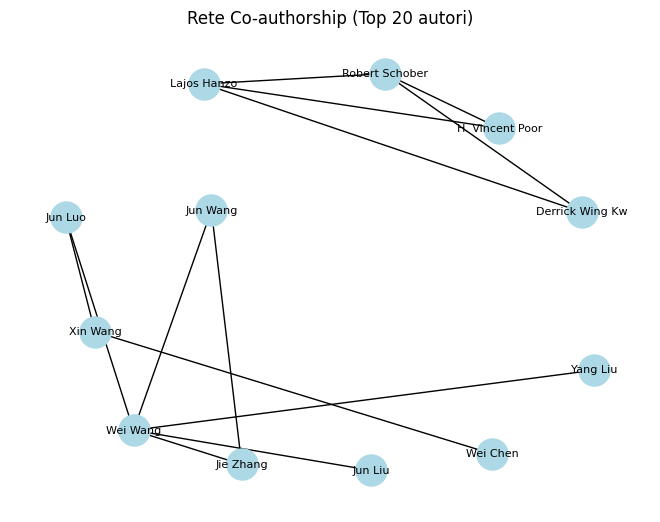

In [7]:
# GRAPH VISUALIZATION WITH NETWORKX

# Create the graph
G = nx.Graph()
for r in coauth_result:
    if r.get('papers', 0) > 0:  # only consider edges with at least 1 co-authored paper
        G.add_edge(r['author1'][:15], r['author2'][:15]) # adds edge between two nodes (names truncated to 15 chars)

# Draw graph
pos = nx.spring_layout(G, seed=42, k=2.5) # 2.5 = node distance
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8)

plt.title('Co-authorship Network (Top 20 Authors)')
plt.axis('off')
plt.show()

## Close Connection

In [8]:
driver.close()
print("\nConnection closed.")


Connessione chiusa.
